In [1]:
import matplotlib.pyplot as plt
from plots.mpltoolkit import mpl_loc, named_colors, fancy_legend, load_mpl_presets, dummy_background_axes, markers
from scipy.stats import bootstrap, skewnorm, linregress
from scipy.optimize import curve_fit, bisect
import numpy as np
import vice
import sys
load_mpl_presets()
print(sys.version_info)

sys.version_info(major=3, minor=12, micro=0, releaselevel='final', serial=0)


In [2]:
output = vice.output("../outputs/inside-out/vrad0")
extra = np.genfromtxt("../outputs/inside-out/vrad0_analogdata.out")
output.stars["absz"] = [abs(_) for _ in extra[:,-1][:output.stars.size[0]]]
# stars = output.stars
stars = output.stars.filter("absz", "<=", 0.5)

In [3]:
ZONE_WIDTH = 0.1

def filter_sample(sample, age_range, radial_range):
    return sample.filter(
        "zone_final", ">=", int(radial_range[0] / ZONE_WIDTH)).filter(
        "zone_final", "<=", int(radial_range[1] / ZONE_WIDTH) - 1).filter(
        "age", ">=", age_range[0]).filter(
        "age", "<=", age_range[1])

def get_distributions(sample, age_range, radial_range, radial_bins, oh_bins):
    sample = filter_sample(sample, age_range, radial_range)
    sub["rbirth"] = [ZONE_WIDTH * (zone + 0.5) for zone in sub["zone_origin"]]
    hist_kwargs = {
        "weights": sub["mass"],
        "density": True
    }
    rbirth_dist, _ = np.histogram(sub["rbirth"], bins = radial_bins, **hist_kwargs)
    oh_dist, _ = np.histogram(sub["[o/h]"], bins = oh_bins, **hist_kwargs)
    return [rbirth_dist, oh_dist]

def plot_distributions(ax_radial, ax_oh, sample, age_range, radial_range, radial_bins, oh_bins, **kwargs):
    rbirth_dist, oh_dist = get_distributions(sample, age_range, radial_range, radial_bins, oh_bins)
    xvals = [(a + b) / 2 for a, b in zip(radial_bins[1:], radial_bins[:-1])]
    ax_radial.plot(xvals, rbirth_dist, **kwargs)
    xvals = [(a + b) / 2 for a, b in zip(oh_bins[1:], oh_bins[:-1])]
    ax_oh.plot(xvals, oh_dist, **kwargs)

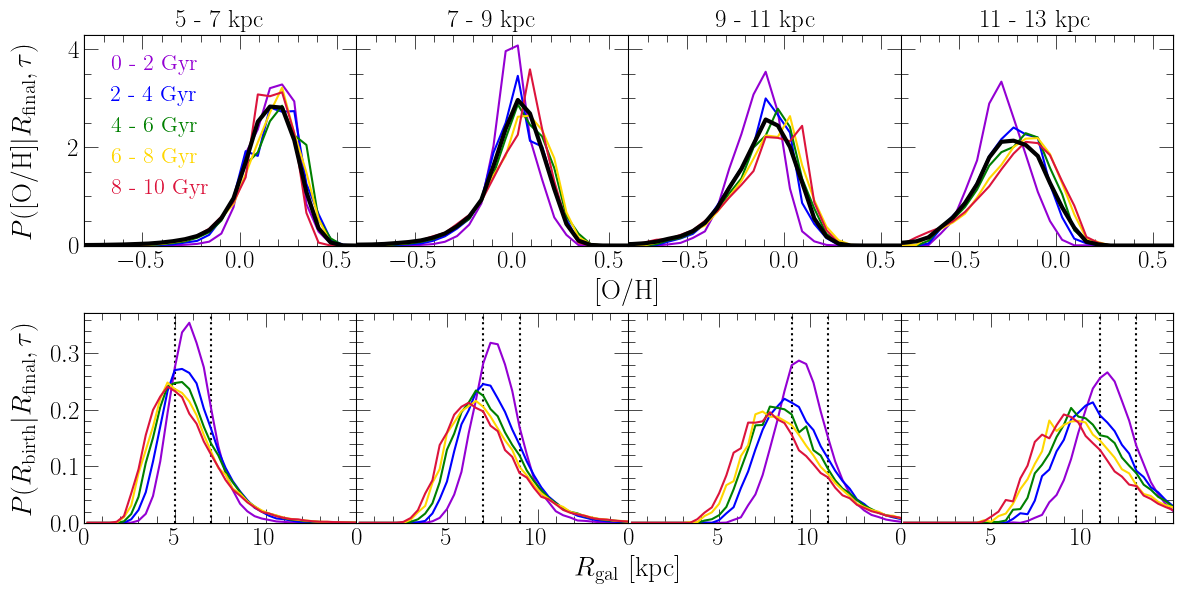

In [7]:
RADIAL_RANGES = [5, 7, 9, 11, 13]
AGE_RANGES = [0, 2, 4, 6, 8, 10]
RADIAL_BINS = np.linspace(0, 20, 51)
OH_BINS = np.linspace(-1.5, 1, 41)
COLORS = ["darkviolet", "blue", "green", "gold", "crimson"]

fig = plt.figure(figsize = (12, 6))
top = []
bottom = []
for i in range(4):
    kwargs = {}
    if i: kwargs["sharey"] = top[0]
    top.append(fig.add_subplot(241 + i, **kwargs))
    top[i].set_xlim([-0.8, 0.6])
    top[i].set_xticks([-0.5, 0, 0.5])
    top[i].set_title("%d - %d kpc" % (RADIAL_RANGES[i], RADIAL_RANGES[i + 1]))
    if i: kwargs["sharey"] = bottom[0]
    bottom.append(fig.add_subplot(245 + i, **kwargs))
    bottom[i].set_xlim([0, 15])
    bottom[i].set_xticks([0, 5, 10])
    bottom[i].set_yticks([0, 0.1, 0.2, 0.3])
    if i:
        plt.setp(top[i].get_yticklabels(), visible = False)
        plt.setp(bottom[i].get_yticklabels(), visible = False)
    else: pass
    top_dummy = fig.add_subplot(211, zorder = -1000)
    bottom_dummy = fig.add_subplot(212, zorder = -1000)
    for dummy in [top_dummy, bottom_dummy]:
        plt.setp(dummy.get_xticklabels(), visible = False)
        plt.setp(dummy.get_yticklabels(), visible = False)

for i in range(len(RADIAL_RANGES) - 1):
    kwargs = {
        "c": named_colors()["black"],
        "linestyle": ":"
    }
    bottom[i].axvline(RADIAL_RANGES[i], **kwargs)
    bottom[i].axvline(RADIAL_RANGES[i + 1], **kwargs)
    for j in range(len(AGE_RANGES) - 1):
        kwargs = {
            "c": named_colors()[COLORS[j]],
            "label": "%d - %d Gyr" % (AGE_RANGES[j], AGE_RANGES[j + 1])
        }
        plot_distributions(bottom[i], top[i], stars, AGE_RANGES[j:(j + 2)], RADIAL_RANGES[i:(i + 2)],
            RADIAL_BINS, OH_BINS, **kwargs)
    sub = stars.filter(
        "zone_final", ">=", int(RADIAL_RANGES[i] / ZONE_WIDTH)).filter(
        "zone_final", "<=", int(RADIAL_RANGES[i + 1] / ZONE_WIDTH) - 1)
    oh_dist, _ = np.histogram(sub["[o/h]"], bins = OH_BINS, weights = sub["mass"], density = True)
    xvals = [(a + b) / 2 for a, b in zip(OH_BINS[:-1], OH_BINS[1:])]
    top[i].plot(xvals, oh_dist, c = named_colors()["black"], linewidth = 3)

kwargs = {
    "loc": mpl_loc("upper left"),
    "handlelength": 0,
    "ncol": 1,
    "fontsize": 16
}
leg = top[0].legend(**kwargs)
fancy_legend(leg, COLORS)

top[0].set_ylim([0, top[0].get_ylim()[1]])
bottom[0].set_ylim([0, bottom[0].get_ylim()[1]])

plt.tight_layout()
plt.subplots_adjust(wspace = 0, hspace = 0.32, left = 0.08, bottom = 0.12)
top_dummy.set_xlabel("[O/H]", labelpad = 20)
top_dummy.set_ylabel(r"$P(\text{[O/H]} | R_\text{final}, \tau)$", labelpad = 30)
bottom_dummy.set_xlabel(r"$R_\text{gal}$ [kpc]", labelpad = 20)
bottom_dummy.set_ylabel(r"$P(R_\text{birth} | R_\text{final}, \tau)$", labelpad = 30)
top_dummy.set_position([
    top[0].get_position().x0,
    top[0].get_position().y0,
    top[-1].get_position().x1 - top[0].get_position().x0,
    top[0].get_position().y1 - top[0].get_position().y0
])
bottom_dummy.set_position([
    bottom[0].get_position().x0,
    bottom[0].get_position().y0,
    bottom[-1].get_position().x1 - bottom[0].get_position().x0,
    bottom[0].get_position().y1 - bottom[0].get_position().y0
])
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./rbirth-oh-distributions/rbirth-oh-distributions-insideout-vrad0.%s" % (ext), **kwargs)
plt.show()

There is an effect of the correct sign in that the birth radius shifts inward for older populations at a fixed present day radius. This does imprint on the metallicity distributions conditioned on both age and present day radius in that older populations have a slightly more metal rich mode. However, the effect seems to be stronger in birth radius than metallicity. For example, in the outermost radial bin here (11 - 13 kpc), stars in the oldest age bin tend to be born at 8 -  10 kpc. However, the mode of the MDF for these stars is only ~0.2 dex higher than it is for the youngest stars at this radius.

Intuitively, I expect that this is due to the relatively shallow nature of the abundance gradient in this model. For a gradient of slope -0.06 dex/kpc (my measurement of $\nabla$[O/H] for the bulk population), stars that migrate 5 kpc outward in radius are only 0.3 dex more metal rich than the in-situ stars.

However, one noticeable difference between this model and the h277 distributions $P(R_\text{birth} | R_\text{final}, \tau)$ shown in the bottom panels of Fig. 1 in Johnson et al. (2021) is in the *tails* of the distribution. Here, they are relatively age independent toward high $R$. In h277, it is more of a uniform shift inward; the tails do not match up, and the distribution is more of a uniform inward shift. Nonetheless, much of the effect in the inner Galaxy and out to the solar neighborhood is well reproduced. 9-11 kpc looks good as well, with the exception of the 8-10 Gyr old bin.

Making Sense of It
------------------

Because the a star's birth radius $R_\text{birth}$, present-day radius $R_\text{final}$, age $\tau$, and metallicity [O/H] are all correlated with one another, it is not straightforward to relate distributions in different quantities conditioned on one another. The relation can be derived with an application of the chain rule. Generically,

$$
P(a, b, c) = P(c) P(b | c) P(a | b, c).
$$

By substituting in for $a$, $b$, and $c$, we arrive at the following sequence of expressions:

$$
\begin{align}
P(R_\text{birth}, R_\text{final}, \tau) &= P(\tau) P(R_\text{final} | \tau) P(R_\text{birth} | R_\text{final}, \tau)
\\
P(\text{[O/H]}, R_\text{final}, \tau) &= P(\tau) P(R_\text{final} | \tau) P(\text{[O/H]} | R_\text{final}, \tau)
\\
\implies P(\tau) P(R_\text{final} | \tau) &= \frac{P(\text{[O/H]}, R_\text{final}, \tau)}{P(\text{[O/H]} | R_\text{final}, \tau)}
= \frac{P(R_\text{birth}, R_\text{final}, \tau)}{P(R_\text{birth} | R_\text{final}, \tau)},
\end{align}
$$

which yields the following relation between the two distributions:

$$
P(R_\text{birth} | R_\text{final}, \tau) = P(\text{[O/H]} | R_\text{final}, \tau)
\frac{P(R_\text{birth}, R_\text{final}, \tau)}{P(\text{[O/H]}, R_\text{final}, \tau)}.
$$

In short, the two are related by the ratio of probabilities that each combination of abundance, birth and final radii, and age would be drawn randomly from the full underlying distribution of stars. With increasing age, however, the correlation between these quantities weakens due to radial mixing. Although they may not become entirely independent with one another, it is enlightening to consider such a limiting scenario, in which case the relation becomes

$$
\begin{align}
P(R_\text{birth} | R_\text{final}, \tau = \text{large}) &\approx P(\text{[O/H]} | R_\text{final}, \tau = \text{large})
\frac{P(R_\text{birth}) P(R_\text{final}) P(\tau = \text{large})}{P(\text{[O/H]}) P(R_\text{final}) P(\tau = \text{large})}
\\
&\approx P(\text{[O/H]} | R_\text{final}, \tau = \text{large}) \frac{d\text{[O/H]}}{dR_\text{birth}}.
\end{align}
$$

As expected, the shift in the [O/H] distribution due to outward migrators is only as large as the radial metallicity gradient allows.

Now let's look at a figure that directly plots the mode of the distribution against the ISM abundance at the corresponding lookback time for different radial ranges.

In [4]:
def skewnormal(x, a, mean, std):
    return 1 / std * skewnorm.pdf((x - mean) / std, a)

def skewnormal_estimate_mode(a, mean, std):
    r"""See notes in apogee.ipynb"""
    delta = a / np.sqrt(1 + a**2)
    term1 = (4 - np.pi) / 2 * delta**3 / (np.pi - 2 * delta**2)
    sgn = int(a > 0) - int(a < 0)
    factor = np.sqrt(2 / np.pi) * (delta - term1) - sgn / 2 * np.exp(-2 * np.pi / abs(a))
    return mean + std * factor

def skewnormal_mode_sample(sample, bins = np.linspace(-3, 2, 1001), **kwargs):
    centers = [(a + b) / 2 for a, b in zip(bins[:-1], bins[1:])]
    dist, _ = np.histogram(sample, bins = bins, density = True, **kwargs)
    try:
        opt, cov = curve_fit(skewnormal, centers, dist, p0 = [1, 0, 1])
    except RuntimeError:
        return float("nan")
    return skewnormal_estimate_mode(opt[0], opt[1], opt[2])

i = 9    


/var/folders/mh/jf6nfbl941l_41vvvwwk5wbr0000gn/T/ipykernel_14147/3047493944.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


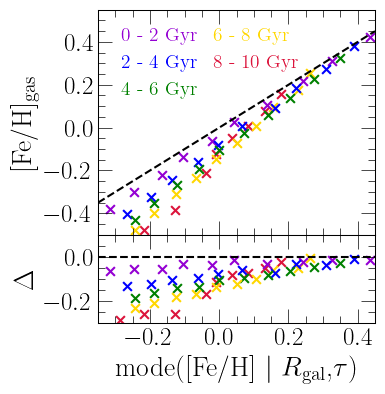

In [35]:
ELEMENT = "Fe"
RADIAL_RANGES = list(range(3, 14))
# RADIAL_RANGES = [3, 5, 7, 9, 11, 13]
AGE_RANGES = [0, 2, 4, 6, 8, 10]
RADIAL_BINS = np.linspace(0, 20, 51)
OH_BINS = np.linspace(-1.5, 1, 41)
COLORS = ["darkviolet", "blue", "green", "gold", "crimson"]

fig = plt.figure(figsize = (4, 4))
ax = fig.add_subplot(111)
plt.setp(ax.get_xticklabels(), visible = False)
ax.set_ylabel(r"[%s/H]$_\text{gas}$" % (ELEMENT))
ax.set_xlim([-0.35, 0.45])
ax.set_xticks([-0.2, 0, 0.2, 0.4])
ax.set_ylim([-0.5, 0.55])
ax.set_yticks([-0.4, -0.2, 0, 0.2, 0.4])
ax.plot(ax.get_xlim(), ax.get_xlim(), c = named_colors()["black"], linestyle = '--')
res = fig.add_axes([0.1, 0.1, 0.1, 0.1], sharex = ax)
res.set_xlabel(r"mode([%s/H] $|$ $R_\text{gal}$,$ \tau$)" % (ELEMENT))
res.set_ylabel(r"$\Delta$")
res.set_ylim([-0.3, 0.1])
res.set_yticks([-0.2, 0])
res.axhline(0, c = named_colors()["black"], linestyle = '--')

with open("./rbirth-oh-distributions/mode-%sh-ism.vectors" % (ELEMENT.lower()), "w") as out:
    out.write("# age_min [Gyr]    age_max [Gyr]    ")
    out.write("R_min [kpc]    R_max [kpc]    ")
    out.write("mode([%s/H])    [%s/H]_gas\n" % (ELEMENT.capitalize(), ELEMENT.capitalize()))
    for i in range(len(RADIAL_RANGES) - 1):
        sys.stdout.write("\ri = %d    " % (i))
        for j in range(len(AGE_RANGES) - 1):
            out.write("%.3e\t%.3e\t%.3e\t%.3e\t" % (AGE_RANGES[j], AGE_RANGES[j + 1],
                RADIAL_RANGES[i], RADIAL_RANGES[i + 1]))
            radius = (RADIAL_RANGES[i] + RADIAL_RANGES[i + 1]) / 2
            zone = int(radius / ZONE_WIDTH)
            lookback = (AGE_RANGES[j] + AGE_RANGES[j + 1]) / 2
            diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
            idx = diff.index(min(diff))
            gas_phase = output.zones["zone%d" % (zone)].history["[%s/h]" % (ELEMENT)][idx]
            sub = filter_sample(stars, AGE_RANGES[j:(j + 2)], RADIAL_RANGES[i:(i + 2)])
            mode_xh = skewnormal_mode_sample(sub["[%s/h]" % (ELEMENT)], bins = OH_BINS, weights = sub["mass"])
            out.write("%.3e\t%.3e\n" % (mode_xh, gas_phase))
            kwargs = {
                "c": named_colors()[COLORS[j]],
                "marker": markers()["x"],
                "s": 40
            }
            if not i: kwargs["label"] = "%d - %d Gyr" % (AGE_RANGES[j], AGE_RANGES[j + 1])
            ax.scatter(mode_xh, gas_phase, **kwargs)
            delta = gas_phase - mode_xh
            res.scatter(mode_xh, delta, **kwargs)
    sys.stdout.write("\n")
    out.close()

kwargs = {
    "loc": mpl_loc("upper left"),
    "handlelength": 0,
    "ncol": 2,
    "fontsize": 14,
    "columnspacing": 0.5
    # "bbox_to_anchor": (1.03, -0.03)
}
leg = ax.legend(**kwargs)
fancy_legend(leg, COLORS)

plt.tight_layout()
plt.subplots_adjust(bottom = 0.4, right = 0.95)
res.set_position([
    ax.get_position().x0,
    0.18,
    ax.get_position().x1 - ax.get_position().x0,
    0.22
])
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./rbirth-oh-distributions/mode-%sh-versus-ism.%s" % (ELEMENT.lower(), ext), **kwargs)
plt.show()

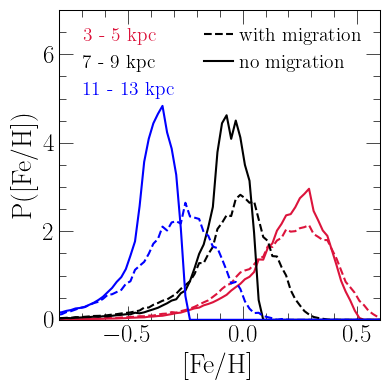

In [34]:
ELEMENT = "Fe"
# RADIAL_RANGES = [3, 5, 7, 9, 11, 13]
RADIAL_RANGES = [[3, 5], [7, 9], [11, 13]]
OH_BINS = np.linspace(-1, 1, 101)
ZONE_WIDTH = 0.1
COLORS = ["crimson", "black", "blue"]
# colors = ["crimson", "gold", "green", "blue", "darkviolet"]

fig = plt.figure(figsize = (4, 4))
ax = fig.add_subplot(111)
ax.set_xlabel("[%s/H]" % (ELEMENT.capitalize()))
ax.set_ylabel("P([%s/H])" % (ELEMENT.capitalize()))

### OXYGEN ###
ax.set_xlim([-0.8, 0.6])
ax.set_xticks([-0.5, 0, 0.5])
ax.set_ylim([0, 9])

### IRON ###
ax.set_xlim([-0.8, 0.6])
ax.set_xticks([-0.5, 0, 0.5])
ax.set_ylim([0, 7])

kwargs = {
    "c": named_colors()["black"],
    "linestyle": '--',
    "label": "with migration"
}
line1 = ax.plot([-10, -9], [-10, -9], **kwargs)[0]
kwargs["linestyle"] = "-"
kwargs["label"] = "no migration"
line2 = ax.plot([-10, -9], [-10, -9], **kwargs)[0]
kwargs = {
    "loc": mpl_loc("upper right"),
    "handlelength": 1.5,
    "ncol": 1,
    "fontsize": 14
}
leg1 = ax.legend(**kwargs)
ax.add_artist(leg1)
line1.remove()
line2.remove()

xvals = [(a + b) / 2 for a, b in zip(OH_BINS[:-1], OH_BINS[1:])]
for i in range(len(RADIAL_RANGES)):
    sub = stars.filter(
        "zone_origin", ">=", int(RADIAL_RANGES[i][0] / ZONE_WIDTH)).filter(
        "zone_origin", "<=", int(RADIAL_RANGES[i][1] / ZONE_WIDTH) - 1)
    kwargs = {
        "bins": OH_BINS,
        "weights": sub["mass"],
        "density": True
    }
    oh_dist, _ = np.histogram(sub["[%s/h]" % (ELEMENT)], **kwargs)
    ax.plot(xvals, oh_dist, c = named_colors()[COLORS[i]],
        # label = "%g kpc" % ((RADIAL_RANGES[i][0] + RADIAL_RANGES[i][1]) / 2))
        label = "%d - %d kpc" % (RADIAL_RANGES[i][0], RADIAL_RANGES[i][1]))
    sub = stars.filter(
        "zone_final", ">=", int(RADIAL_RANGES[i][0] / ZONE_WIDTH)).filter(
        "zone_final", "<=", int(RADIAL_RANGES[i][1] / ZONE_WIDTH) - 1)
    kwargs["weights"] = sub["mass"]
    oh_dist, _ = np.histogram(sub["[%s/h]" % (ELEMENT)], **kwargs)
    ax.plot(xvals, oh_dist, c = named_colors()[COLORS[i]], linestyle = '--')

kwargs = {
    "loc": mpl_loc("upper left"),
    "handlelength": 0,
    "ncol": 1,
    "fontsize": 14
}
leg = ax.legend(**kwargs)
fancy_legend(leg, COLORS)

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./rbirth-oh-distributions/%sh-dfs-with-vs-no-migration.%s" % (ELEMENT.lower(), ext), **kwargs)
plt.show()

In [ ]:
fig = plt.figure(figsize = (4, 4))


[-0.0890587112303122, -0.08833865688972206, -0.08741824405383958, -0.08628113369398904, -0.08533199542504148, -0.0843807403144082, -0.08357784384204817, -0.08296705961626662, -0.08306021506711922, -0.08499521168700577, -0.09000009072516224, -0.10391688603801327]
[0.4015207961411902, 0.4602082072039825, 0.5100831514567731, 0.5264273879629285, 0.5374849483142055, 0.5636817087554302, 0.5551827620229153, 0.5687767624005053, 0.5684832010852615, 0.5705299499989026, 0.6365876688273712, 0.819880503081684]


/var/folders/26/nqb98q9x5_q6brmqy4v21dqm0000gp/T/ipykernel_21521/1434079756.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


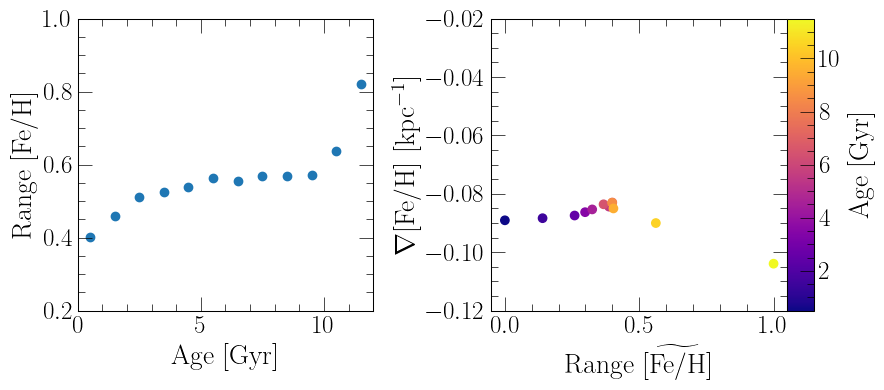

In [35]:
ELEMENT = "Fe"
ZONE_WIDTH = 0.1
AGE_BINS = list(range(13))

fig = plt.figure(figsize = (9, 4))
ax1 = fig.add_subplot(121)
ax1.set_xlabel(r"Age [Gyr]")
ax1.set_ylabel("Range [%s/H]" % (ELEMENT))
ax1.set_xlim([0, 12])
ax1.set_ylim([0.2, 1.0])
ax2 = fig.add_subplot(122)
ax2.set_xlabel(r"Range $\widetilde{\text{[%s/H]}}$" % (ELEMENT))
ax2.set_ylabel(r"$\nabla$[%s/H] [kpc$^{-1}$]" % (ELEMENT))
ax2.set_xlim([-0.05, 1.05])
ax2.set_ylim([-0.12, -0.02])

def clipped_range(arr, weights):
    indeces = np.argsort(arr)
    weights = [w / sum(weights) for w in weights]
    s = 0
    fifth = None
    ninetyfifth = None
    for i in indeces:
        s += weights[i]
        if fifth is None and s > 0.05:
            fifth = i
        elif ninetyfifth is None and s > 0.95:
            ninetyfifth = i
        else: continue
    if fifth is None or ninetyfifth is None:
        return float("nan")
    else:
        fifth = arr[fifth]
        ninetyfifth = arr[ninetyfifth]
        return ninetyfifth - fifth

def normalize_ranges(ranges):
    minrange = min(ranges)
    maxrange = max(ranges)
    diff = maxrange - minrange
    return [(_ - minrange) / diff for _ in ranges]

oh_measured = []
feh_measured = []
age_measured = []
for i in range(len(stars["age"])):
    oh_measured.append(np.random.normal(loc = stars["[o/h]"][i], scale = 0.03))
    feh_measured.append(np.random.normal(loc = stars["[fe/h]"][i], scale = 0.03))
    age_measured.append(np.random.normal(loc = stars["age"][i], scale = 0.5))
stars["[o/h]_measured"] = oh_measured
stars["[fe/h]_measured"] = feh_measured
stars["age_measured"] = age_measured

slopes = []
ranges = []
for i in range(len(AGE_BINS) - 1):
    sub = stars.filter(
        "age_measured", ">=", AGE_BINS[i]).filter(
        "age_measured", "<=", AGE_BINS[i + 1]).filter(
        "zone_origin", "<=", int(15 / ZONE_WIDTH)).filter(
        "zone_origin", ">=", int(3 / ZONE_WIDTH))
    sub["rbirth"] = [ZONE_WIDTH * (_ + 0.5) for _ in sub["zone_origin"]]
    line = linregress(sub["rbirth"], sub["[%s/h]_measured" % (ELEMENT)])
    slopes.append(line.slope)
    sub = sub.filter(
        "zone_final", ">=", int(7 / ZONE_WIDTH)).filter(
        "zone_final", "<=", int(10 / ZONE_WIDTH))
    ranges.append(clipped_range(sub["[%s/h]_measured" % (ELEMENT)], sub["mass"]))

print(slopes)
print(ranges)

age_centers = [(a + b) / 2 for a, b in zip(AGE_BINS[:-1], AGE_BINS[1:])]
ax1.scatter(age_centers, ranges)
sc = ax2.scatter(normalize_ranges(ranges), slopes, c = age_centers, cmap = "plasma")
cbar_ax = fig.add_axes([0.1, 0.1, 0.1, 0.1])
cbar = plt.colorbar(sc, cax = cbar_ax, orientation = "vertical")
cbar.set_label("Age [Gyr]")
cbar.set_ticks([2, 4, 6, 8, 10])

plt.tight_layout()
plt.subplots_adjust(right = 0.88, wspace = 0.4)
cbar_ax.set_position([
    ax2.get_position().x1,
    ax2.get_position().y0,
    0.03,
    ax2.get_position().y1 - ax2.get_position().y0
])
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./rbirth-oh-distributions/lucys-calculations-%s.%s" % (ELEMENT, ext), **kwargs)
plt.show()